**Credit Card Fraud Detection using RF & XGB**


NAME : KISHORE DM
CONTACT: 8098209685
         kishoredm97@gmail.com




In [1]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'creditcardfraud:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F310%2F23498%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240414%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240414T165116Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D49e53e970fb53ded1f5a5d9796d1bd30f805c8c38632bbf3f4fe2fa875d0751d3287dd4b9e6350301ac9dcff400f7e87d59aef4cd06b13d4d600f6cda5d8671242920eeef9a7a0164c1fa4273d9d84c281fea4ee3720cbd9f1debfe7c4aefe8dcc442df8497c4bed626417ac0b9dff181608a17a99638f7d51d2c9e5539a1601d6ab466d8f515cc36c8862b022bf194039a588549d1c5659bf5f98f69aebebc7530b62936f1163fe1e37f5f72b34857c6dd871739b4a6d65edce677e7d95bd956745692538cd90e800ac8e6a878dfddf5d2fee8b41ae09ca20a3c0cf0c500c2bf7600e6e737e1506da0449128d9139566a5425adb2fa329ecf444e4558d888aa'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 69155672 bytes downloaded
Downloaded and uncompressed: creditcardfraud
Data source import complete.


# ***CREDIT CARD FRAUD DETECTION***

# 2.0 About Data
- Title: Credit Card Fraud Detection
- Dataset: [link](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

  ## Metadata
  
  `Description:`** The dataset contains transactions made by credit cards in September 2013 by European cardholders.
  
  **`Data Age:`** Updated (03/05/2021)
  
  **`License:`** Database: Open Database, Contents: Database Contents

### 2.1 Task:
 Exploring the Iris Flower Dataset involves a step-by-step process. First, we clean and prepare the data to ensure it's accurate and consistent. Then, we summarize the data using descriptive statistics like averages and ranges. Next, we visualize the data with charts and graphs to see patterns and relationships. We detect outliers, which are unusual data points, and test our assumptions about the data. After pre-processing, we train a machine learning model and then call, train, and predict the model.

### 2.3 Kernel Version Used:
- Python 3.11.5

# ***3.0 Data Preparation:***

# 3.1 Import Libraries

Let's start the project by impoprting all the libraries that we will need in this project.

In [2]:
# import libraries

# 1. to handle the data
import pandas as pd
import numpy as np

# to visualize the dataset
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# To preprocess the data
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

# machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
#for classification tasks
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor
from xgboost import XGBClassifier
#metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# 3.2 Data Loading and Exploration | Cleaning

### 3.2.1 Load the Dataset

In [3]:
# load the data from csv file placed locally in our pc
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

### Set the option to show maximum columns:

In [4]:
pd.set_option('display.max_columns', None)

### 3.2.2 Get a sneak peek of data:
The purpose of a sneak peek is to get a quick overview of the data and identify any potential problems or areas of interest.

In [5]:
# print the first 5 rows of the dataframe
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# 3.2.3 Explore the Data

In [6]:
# exploring the datatype of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Let's have a look on the shape of the dataset:

In [7]:
# data shpae
df.shape

(284807, 31)

### Lets see the column name:

In [8]:
# Lets see the column name
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

# Observation Set 1:
- There are 284807 rows and 31 columns in the dataset.
- The data type of all columns is numeric (int and float).
-  The columns in the datasets are:
   - 'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
      'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
      'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
      'Class'

---

# 3.2.4 Descriptive Statistics:

Descriptive statistics are a collection of quantitative measures that summarize and describe the main characteristics of a dataset.

In [9]:
# Summary Statistics
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


---

## ***3.3 Normalization:***

In [10]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer(norm='l2')
print(normalizer.fit_transform(df))

[[ 0.00000000e+00 -9.08530061e-03 -4.86273988e-04 ... -1.40662094e-04
   9.99658439e-01  0.00000000e+00]
 [ 0.00000000e+00  3.14200001e-01  7.01632379e-02 ...  3.88161797e-03
   7.09143734e-01  0.00000000e+00]
 [ 2.64054194e-03 -3.58679087e-03 -3.53875680e-03 ... -1.57777241e-04
   9.99867610e-01  0.00000000e+00]
 ...
 [ 9.99999922e-01  1.11093644e-05 -1.74348810e-06 ... -1.53719162e-07
   3.92851325e-04  0.00000000e+00]
 [ 9.99999998e-01 -1.39153210e-06  3.07013515e-06 ...  6.04977321e-07
   5.78743893e-05  0.00000000e+00]
 [ 9.99999211e-01 -3.08701850e-06 -1.09804382e-06 ...  7.89903674e-08
   1.25584419e-03  0.00000000e+00]]


# ***3.4 Lets deal with 'Class' column:***

In [11]:
# distribution of legitimate transactions & fraudulent transactions
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [12]:
# separating the data for analysis
legit = df[df['Class'] == 0]
fraud = df[df['Class'] == 1]

In [13]:
# statistical measures of the legit data
legit.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.0
mean,94838.202258,0.008258,-0.006271,0.012171,-0.007860,0.005453,0.002419,0.009637,-0.000987,0.004467,0.009824,-0.006576,0.010832,0.000189,0.012064,0.000161,0.007164,0.011535,0.003887,-0.001178,-0.000644,-0.001235,-0.000024,0.000070,0.000182,-0.000072,-0.000089,-0.000295,-0.000131,88.291022,0.0
std,47484.015786,1.929814,1.636146,1.459429,1.399333,1.356952,1.329913,1.178812,1.161283,1.089372,1.044204,1.003112,0.945939,0.995067,0.897007,0.915060,0.844772,0.749457,0.824919,0.811733,0.769404,0.716743,0.723668,0.621541,0.605776,0.520673,0.482241,0.399847,0.329570,250.105092,0.0
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-31.764946,-73.216718,-6.290730,-14.741096,-4.797473,-15.144988,-5.791881,-18.392091,-4.391307,-10.115560,-17.098444,-5.366660,-7.213527,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.0
25%,54230.000000,-0.917544,-0.599473,-0.884541,-0.850077,-0.689398,-0.766847,-0.551442,-0.208633,-0.640412,-0.532880,-0.763447,-0.402102,-0.648067,-0.422453,-0.582812,-0.465543,-0.482644,-0.497414,-0.456366,-0.211764,-0.228509,-0.542403,-0.161702,-0.354425,-0.317145,-0.327074,-0.070852,-0.052950,5.650000,0.0
50%,84711.000000,0.020023,0.064070,0.182158,-0.022405,-0.053457,-0.273123,0.041138,0.022041,-0.049964,-0.091872,-0.034923,0.141679,-0.013547,0.051947,0.048294,0.067377,-0.064833,-0.002787,0.003117,-0.062646,-0.029821,0.006736,-0.011147,0.041082,0.016417,-0.052227,0.001230,0.011199,22.000000,0.0
75%,139333.000000,1.316218,0.800446,1.028372,0.737624,0.612181,0.399619,0.571019,0.326200,0.598230,0.455135,0.736362,0.619207,0.662492,0.494104,0.648842,0.523738,0.399922,0.501103,0.457499,0.132401,0.185626,0.528407,0.147522,0.439869,0.350594,0.240671,0.090573,0.077962,77.050000,0.0
max,172792.000000,2.454930,18.902453,9.382558,16.875344,34.801666,73.301626,120.589494,18.709255,15.594995,23.745136,10.002190,7.848392,7.126883,10.526766,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,22.614889,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,0.0


In [14]:
legit.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [15]:
# statistical measures of the fraud data
fraud.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.0
mean,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,-5.676883,3.800173,-6.259393,-0.109334,-6.971723,-0.092929,-4.139946,-6.665836,-2.246308,0.680659,0.372319,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321,1.0
std,47835.365138,6.783687,4.291216,7.110937,2.873318,5.372468,1.858124,7.206773,6.797831,2.500896,4.897341,2.678605,4.654458,1.104518,4.278940,1.049915,3.865035,6.970618,2.899366,1.539853,1.346635,3.869304,1.494602,1.579642,0.515577,0.797205,0.471679,1.376766,0.547291,256.683288,0.0
min,406.000000,-30.552380,-8.402154,-31.103685,-1.313275,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,-24.588262,-1.702228,-18.683715,-3.127795,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-3.681904,-4.128186,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.152671,-7.263482,-1.869290,0.000000,1.0
25%,41241.500000,-6.036063,1.188226,-8.643489,2.373050,-4.792835,-2.501511,-7.965295,-0.195336,-3.872383,-7.756698,1.973397,-8.688177,-0.979117,-9.692723,-0.643539,-6.562915,-11.945057,-4.664576,-0.299423,-0.171760,0.041787,-0.533764,-0.342175,-0.436809,-0.314348,-0.259416,-0.020025,-0.108868,1.000000,1.0
50%,75568.500000,-2.342497,2.717869,-5.075257,4.177147,-1.522962,-1.424616,-3.034402,0.621508,-2.208768,-4.578825,3.586218,-5.502530,-0.065566,-6.729720,-0.057227,-3.549795,-5.302949,-1.664346,0.646807,0.284693,0.592146,0.048434,-0.073135,-0.060795,0.088371,0.004321,0.394926,0.146344,9.250000,1.0
75%,128483.000000,-0.419200,4.971257,-2.276185,6.348729,0.214562,-0.413216,-0.945954,1.764879,-0.787850,-2.614184,5.307078,-2.974088,0.672964,-4.282821,0.609189,-1.226043,-1.341940,0.091772,1.649318,0.822445,1.244611,0.617474,0.308378,0.285328,0.456515,0.396733,0.826029,0.381152,105.890000,1.0
max,170348.000000,2.132386,22.057729,2.250210,12.114672,11.095089,6.474115,5.802537,20.007208,3.353525,4.031435,12.018913,1.375941,2.815440,3.442422,2.471358,3.139656,6.739384,3.790316,5.228342,11.059004,27.202839,8.361985,5.466230,1.091435,2.208209,2.745261,3.052358,1.779364,2125.870000,1.0


In [16]:
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [17]:
# compare the values for both transactions
df.groupby('Class').mean()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,94838.202258,0.008258,-0.006271,0.012171,-0.007860,0.005453,0.002419,0.009637,-0.000987,0.004467,0.009824,-0.006576,0.010832,0.000189,0.012064,0.000161,0.007164,0.011535,0.003887,-0.001178,-0.000644,-0.001235,-0.000024,0.000070,0.000182,-0.000072,-0.000089,-0.000295,-0.000131,88.291022
1,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,-5.676883,3.800173,-6.259393,-0.109334,-6.971723,-0.092929,-4.139946,-6.665836,-2.246308,0.680659,0.372319,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321


In [18]:
# Under-Sampling (building sample dataset containing similar distribution of normal transactions and Fraudulent Transactions)
legit_sample = legit.sample(n=492)
# Concatenating two DataFrames
new_df = pd.concat([legit_sample, fraud], axis=0)
# Print first 5 rows of the new dataset
new_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
140036,83502.0,-0.754934,-1.802975,0.866239,-1.690596,-3.007219,1.865597,0.741822,0.098395,-1.798257,0.883077,1.104856,-0.463499,0.123678,-0.672319,-0.251395,-0.624643,0.751892,0.213729,-0.704381,-0.263089,0.243652,1.268334,0.620800,-0.282679,-1.342805,-0.245118,0.375048,0.193864,533.50,0
272666,165208.0,-2.890127,-0.845929,-2.583220,-0.013006,-3.049105,0.904112,2.086269,0.634308,0.500340,-1.110537,-1.840562,0.203581,-0.140252,0.608666,-0.601014,0.987480,-0.231448,-0.423736,0.072074,-1.511173,-0.531408,-0.481769,1.180488,0.637500,-2.243963,-0.192152,0.834151,-0.855238,575.99,0
97542,66265.0,-0.432996,0.919315,1.426107,-0.216701,0.060433,-0.402778,0.535321,0.154992,-0.490157,-0.115832,0.841086,0.027973,-0.936815,0.506166,0.275192,0.536289,-0.711211,0.367335,0.434975,0.059607,-0.208706,-0.620559,-0.062856,-0.047426,-0.211385,0.077546,0.254699,0.105435,3.58,0
4412,3767.0,1.442561,-0.615738,-0.891180,-1.633663,1.479310,3.267070,-1.198687,0.715892,0.362621,0.291951,1.009214,-3.174217,1.865372,1.407701,0.257173,1.530792,0.445434,-0.870203,0.773397,0.178614,-0.291036,-0.887000,0.100046,0.918927,0.364862,-0.506106,-0.015899,0.011726,20.63,0
142411,84701.0,1.094503,0.051973,0.084046,0.920497,0.012089,0.010475,0.030591,0.111480,-0.131221,0.145106,1.084775,0.391024,-0.915495,0.778467,0.596547,0.095359,-0.466401,0.118013,-0.324281,-0.119105,0.102241,0.198007,-0.151306,-0.317430,0.582522,-0.297646,0.011829,0.009342,49.00,0


In [19]:
# Getting the distribution of the classes for the subsample dataset
new_df['Class'].value_counts()

Class
0    492
1    492
Name: count, dtype: int64

# Observation Set 2:
- I have performed the column of Class is divided into two parts: legit and fraud.
- Dividing the class column into two parts resulted in data imbalance, to balance the imbalance I took the sample size of the legitimate part equal to that of the fraud part.

---

# ***4.0 Dealing with missing values:***

Dealing with the missing values is one of the most important part of the data wrangling process, we must deal with the missing values in order to get the correct insights from the data.

In [20]:
# Check Missing Values
df.isnull().sum().sort_values(ascending = False)

Time      0
V16       0
Amount    0
V28       0
V27       0
V26       0
V25       0
V24       0
V23       0
V22       0
V21       0
V20       0
V19       0
V18       0
V17       0
V15       0
V1        0
V14       0
V13       0
V12       0
V11       0
V10       0
V9        0
V8        0
V7        0
V6        0
V5        0
V4        0
V3        0
V2        0
Class     0
dtype: int64

## Milestone 1: There are no missing values in the dataset.
---

# **5.0 Machine Learning:**

# ***5.1 Model Selection and Evaluation:***

#### Lets make X and y in our Data:

In [21]:
new_df.shape

(984, 31)

In [22]:
# Splitting the data into Features & Targets
X = new_df.drop(columns='Class', axis=1)
y = new_df['Class']

#### Train_test_split the Data:

In [23]:
# Splitting the data into Training data & Testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Check whether the data is splitted in 80:20 ratio
print(X.shape, X_train.shape, X_test.shape)

(984, 30) (787, 30) (197, 30)


#### Call, Train and Predict the Model:

In [25]:
# Call the Model
model = RandomForestClassifier(random_state=42)

In [26]:
# import pipeline
from sklearn.pipeline import Pipeline


# Create a pipeline for each model
pipeline = Pipeline([
    ('model', model)
    ])

# Perform cross-validation
scores = cross_val_score(pipeline, X_train, y_train, cv=5)

# Calculate mean accuracy
mean_accuracy = scores.mean()

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)

print("Model:", RandomForestClassifier())
print("Cross-validation Accuracy:", mean_accuracy)
print("Test Accuracy:", accuracy)
print('Recall Score: ', recall_score(y_test, y_pred))
print('Precision Score: ', precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))

best_model = pipeline

# save the best model
import pickle
pickle.dump(best_model, open('iris_model.dot', 'wb'))

Model: RandomForestClassifier()
Cross-validation Accuracy: 0.9440699830686125
Test Accuracy: 0.9187817258883249
Recall Score:  0.8775510204081632
Precision Score:  0.9555555555555556
F1 Score:  0.9148936170212767


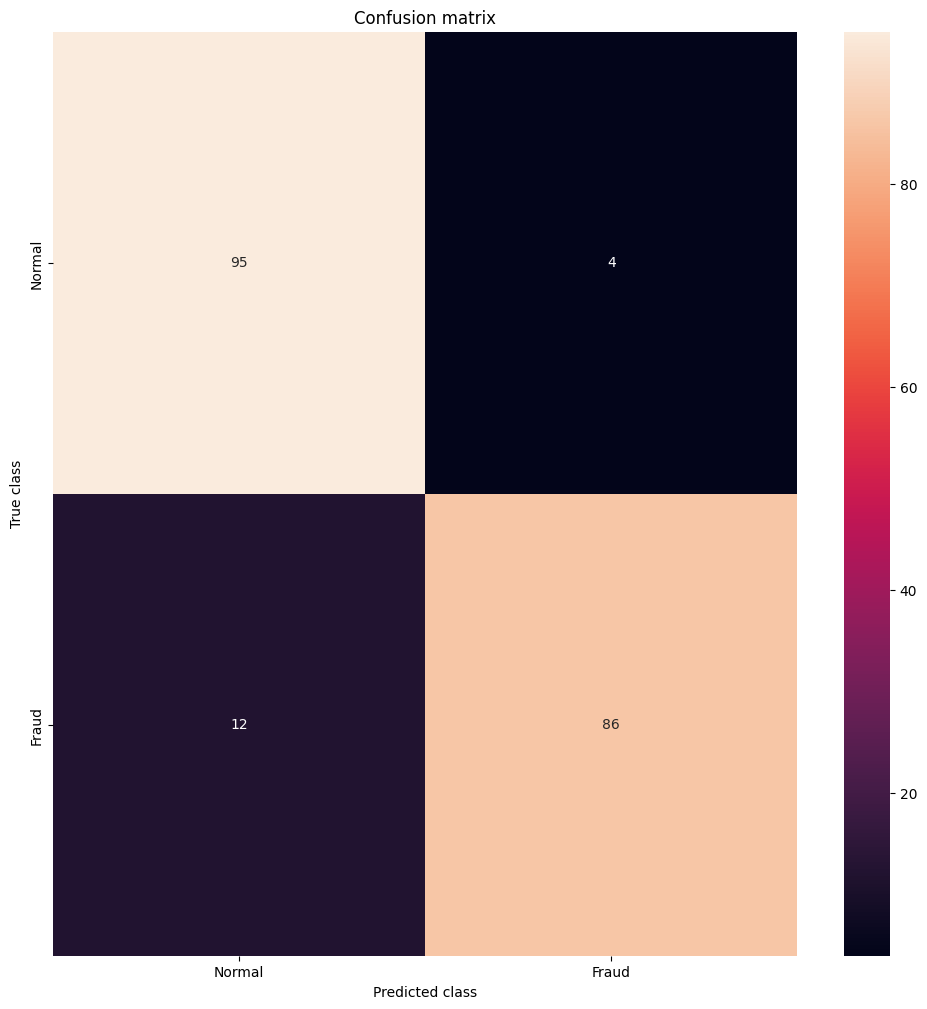

In [27]:
#visulalizing the confusion matrix
LABELS = ['Normal', 'Fraud']
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize =(12, 12))
sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt ="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# ***Feature Engineering:***

In [28]:
df_train = new_df.copy()
df_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
140036,83502.0,-0.754934,-1.802975,0.866239,-1.690596,-3.007219,1.865597,0.741822,0.098395,-1.798257,0.883077,1.104856,-0.463499,0.123678,-0.672319,-0.251395,-0.624643,0.751892,0.213729,-0.704381,-0.263089,0.243652,1.268334,0.620800,-0.282679,-1.342805,-0.245118,0.375048,0.193864,533.50,0
272666,165208.0,-2.890127,-0.845929,-2.583220,-0.013006,-3.049105,0.904112,2.086269,0.634308,0.500340,-1.110537,-1.840562,0.203581,-0.140252,0.608666,-0.601014,0.987480,-0.231448,-0.423736,0.072074,-1.511173,-0.531408,-0.481769,1.180488,0.637500,-2.243963,-0.192152,0.834151,-0.855238,575.99,0
97542,66265.0,-0.432996,0.919315,1.426107,-0.216701,0.060433,-0.402778,0.535321,0.154992,-0.490157,-0.115832,0.841086,0.027973,-0.936815,0.506166,0.275192,0.536289,-0.711211,0.367335,0.434975,0.059607,-0.208706,-0.620559,-0.062856,-0.047426,-0.211385,0.077546,0.254699,0.105435,3.58,0
4412,3767.0,1.442561,-0.615738,-0.891180,-1.633663,1.479310,3.267070,-1.198687,0.715892,0.362621,0.291951,1.009214,-3.174217,1.865372,1.407701,0.257173,1.530792,0.445434,-0.870203,0.773397,0.178614,-0.291036,-0.887000,0.100046,0.918927,0.364862,-0.506106,-0.015899,0.011726,20.63,0
142411,84701.0,1.094503,0.051973,0.084046,0.920497,0.012089,0.010475,0.030591,0.111480,-0.131221,0.145106,1.084775,0.391024,-0.915495,0.778467,0.596547,0.095359,-0.466401,0.118013,-0.324281,-0.119105,0.102241,0.198007,-0.151306,-0.317430,0.582522,-0.297646,0.011829,0.009342,49.00,0


In [29]:
#The function display_feature_importance takes a machine learning model (model) as input and performs feature importance analysis.
def display_feature_importance(model,percentage ,top_n=34, plot=False):
    # X and y
    X = df_train.drop('Class',axis=1)
    y = df_train['Class']

    #The model is fitted using the features (X) and the target variable (y), and then the feature importances are calculated.
    model.fit(X, y)

    # Get feature importance
    feature_importance = model.feature_importances_
    feature_names = X.columns

    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

    # Sort features by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # A threshold is calculated based on a specified percentage of the top feature importance.
    #  Features with importance above this threshold are selected.
    threshold = percentage / 100 * feature_importance_df.iloc[0]['Importance']

    # Select features that meet the threshold
    selected_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]['Feature'].tolist()

    #Print Selected Feature
    print("Selected Features by {} \n \n at threshold {}%; {}".format(model , percentage,selected_features))

    if plot==True:
        # Set seaborn color palette to "viridis"
        sns.set(style="whitegrid", palette="viridis")

        # Display or plot the top features
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n))
        plt.title('Feature Importance for {}'.format(type(model).__name__))
        plt.show()

    # Add 'Exited' to the list of selected features
    selected_features.append('Class')

    return selected_features

In [30]:
# List to store selected features for each model and trial percentage
selected_features_xgb = []

# Initilize AUC List
auc_scores = []

# List of trial percentages
trial_percentages = [3, 5, 10, 20, 40]

# Loop over each trial percentage
for percentage in trial_percentages:
        # Get selected features for each model
        xgb_selected_features = display_feature_importance(XGBClassifier(random_state=42), percentage=percentage)

        # Append selected features to the respective lists
        selected_features_xgb.append(xgb_selected_features)

        # X and y
        X = df_train.drop('Class',axis=1)
        y = df_train['Class']

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Fit models on training data
        xgb_model = XGBClassifier()
        xgb_model.fit(X_train[[feature for feature in xgb_selected_features if feature != 'Class']], y_train, verbose=0)

        # Predict probabilities on the test set
        xgb_pred_proba = xgb_model.predict_proba(X_test[[feature for feature in xgb_selected_features if feature != 'Class']])[:, 1]

        # Calculate AUC scores and append to the list
        from sklearn.metrics import roc_auc_score

        auc_xgb = roc_auc_score(y_test, xgb_pred_proba)
        auc_scores.append((auc_xgb,percentage))

        # Sorted AUC
        sorted_auc = sorted(auc_scores, reverse=True)

# Print Each AUC with Percentage
for score , percentage in sorted_auc :
        print(f'The AUC for {type(xgb_model).__name__ , } \n with {percentage}% of top features is {score:.4f}')

Selected Features by XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...) 
 
 at threshold 3%; ['V14', 'V4', 'V25', 'V7', 'V12', 'V10', 'V8', 'V20', 'Amount', 'V11', 'V1', 'V6']
Selected Features by XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None,

In [31]:
# Impottant Feature Extract Using XGb
imp_fea = ['V14', 'V10', 'V4', 'V7', 'V21', 'V8', 'V20', 'V3', 'V5', 'V11', 'V12', 'V26', 'V17','Class']
df_train = df_train[imp_fea]
df_train.head()

,V14,V10,V4,V7,V21,V8,V20,V3,V5,V11,V12,V26,V17,Class
140036,-0.672319,0.883077,-1.690596,0.741822,0.243652,0.098395,-0.263089,0.866239,-3.007219,1.104856,-0.463499,-0.245118,0.751892,0
272666,0.608666,-1.110537,-0.013006,2.086269,-0.531408,0.634308,-1.511173,-2.583220,-3.049105,-1.840562,0.203581,-0.192152,-0.231448,0
97542,0.506166,-0.115832,-0.216701,0.535321,-0.208706,0.154992,0.059607,1.426107,0.060433,0.841086,0.027973,0.077546,-0.711211,0
4412,1.407701,0.291951,-1.633663,-1.198687,-0.291036,0.715892,0.178614,-0.891180,1.479310,1.009214,-3.174217,-0.506106,0.445434,0
142411,0.778467,0.145106,0.920497,0.030591,0.102241,0.111480,-0.119105,0.084046,0.012089,1.084775,0.391024,-0.297646,-0.466401,0


In [32]:
df_train.shape

(984, 14)

# *Important Feature of  Dataset Train RF and XGB with Hyperparameter Tuning:*

- **RF**

In [33]:
def train_random_forest(data, target):
    # Dictionary to store LabelEncoders for each categorical column
    label_encoders = {}

    # split the data into X and y
    X = data.drop(target, axis=1)
    y = data[target]

    # split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # # Scaling Data
    # scaler = MinMaxScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)

    # Define the Random Forest model
    rf_model = RandomForestClassifier(random_state=0,class_weight='balanced')

    # Define hyperparameters for tuning
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Perform GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Get the best model and parameters
    best_rf_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Print the best hyperparameters
    print('Best Hyperparameters:')
    print(best_params)

    # Train the model on the full training set
    best_rf_model.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred_rf = best_rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_rf)
    precision = precision_score(y_test, y_pred_rf)
    recall = recall_score(y_test, y_pred_rf)

    print(f'Accuracy on Test Set: {accuracy:.2f}')
    print(f'Precision on Test Set: {precision:.2f}')
    print(f'Recall on Test Set: {recall:.2f}')

    #visulalizing the confusion matrix
    LABELS = ['Normal', 'Fraud']
    from sklearn.metrics import confusion_matrix
    conf_matrix = confusion_matrix(y_test, y_pred_rf)
    plt.figure(figsize =(12, 12))
    sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt ="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

    return best_rf_model, best_params, accuracy


Best Hyperparameters:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy on Test Set: 0.93
Precision on Test Set: 0.94
Recall on Test Set: 0.91


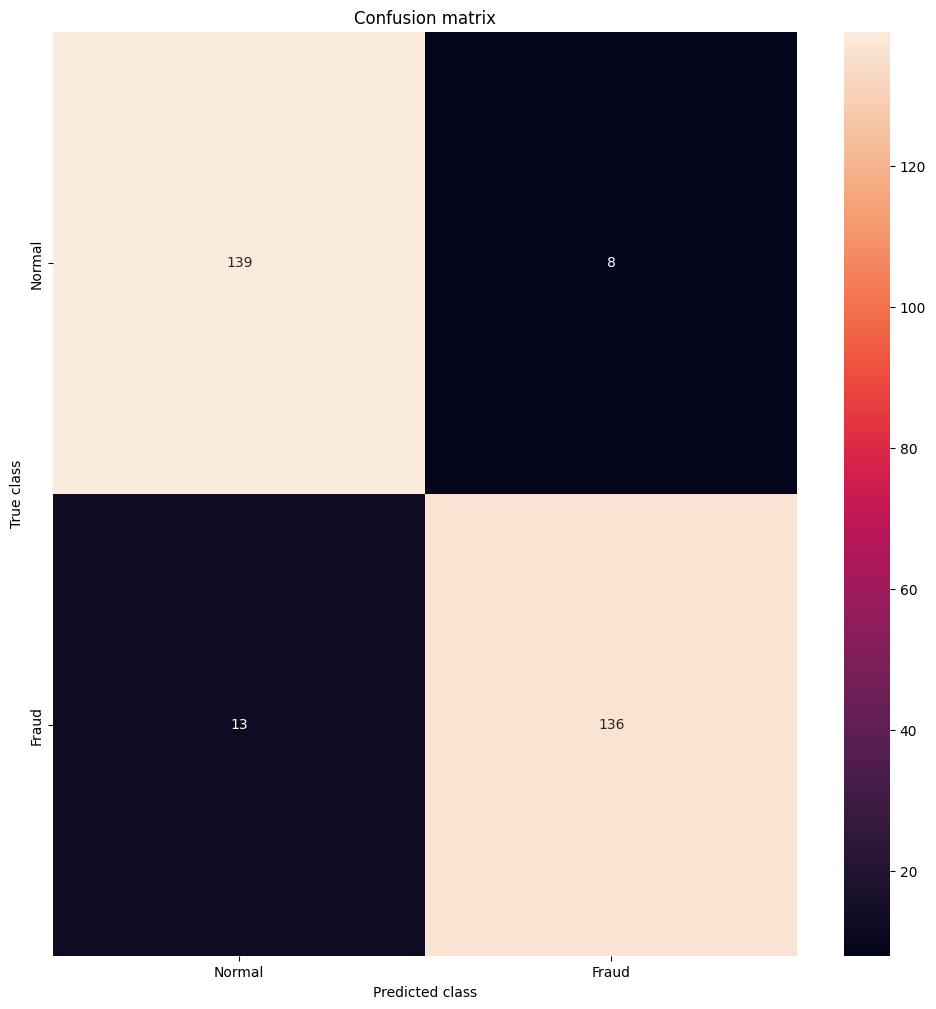

(RandomForestClassifier(class_weight='balanced', n_estimators=50, random_state=0),
 {'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 50},
 0.9290540540540541)

In [34]:
train_random_forest(df_train,'Class')

- **XGB**

In [35]:
def train_xgb_classifier(data, target):
    # split the data into X and y
    X = data.drop(target, axis=1)
    y = data[target]

    # split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


    # # Scaling Data
    # scaler = MinMaxScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)

    # Define the XGBClassifier model
    xgb_model = XGBClassifier(random_state=0)

    # Define hyperparameters for tuning
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 1, 2]
    }

    # Perform GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Get the best model and parameters
    best_xgb_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Print the best hyperparameters
    print('Best Hyperparameters:')
    print(best_params)

    # Train the model on the full training set
    best_xgb_model.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred_xgb = best_xgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_xgb)
    precision = precision_score(y_test, y_pred_xgb)
    recall = recall_score(y_test, y_pred_xgb)

    print(f'Accuracy on Test Set: {accuracy:.2f}')
    print(f'Precision on Test Set: {precision:.2f}')
    print(f'Recall on Test Set: {recall:.2f}')

    #visulalizing the confusion matrix
    LABELS = ['Normal', 'Fraud']
    from sklearn.metrics import confusion_matrix
    conf_matrix = confusion_matrix(y_test, y_pred_xgb)
    plt.figure(figsize =(12, 12))
    sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt ="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()


    return best_xgb_model, best_params

Best Hyperparameters:
{'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Accuracy on Test Set: 0.93
Precision on Test Set: 0.94
Recall on Test Set: 0.91


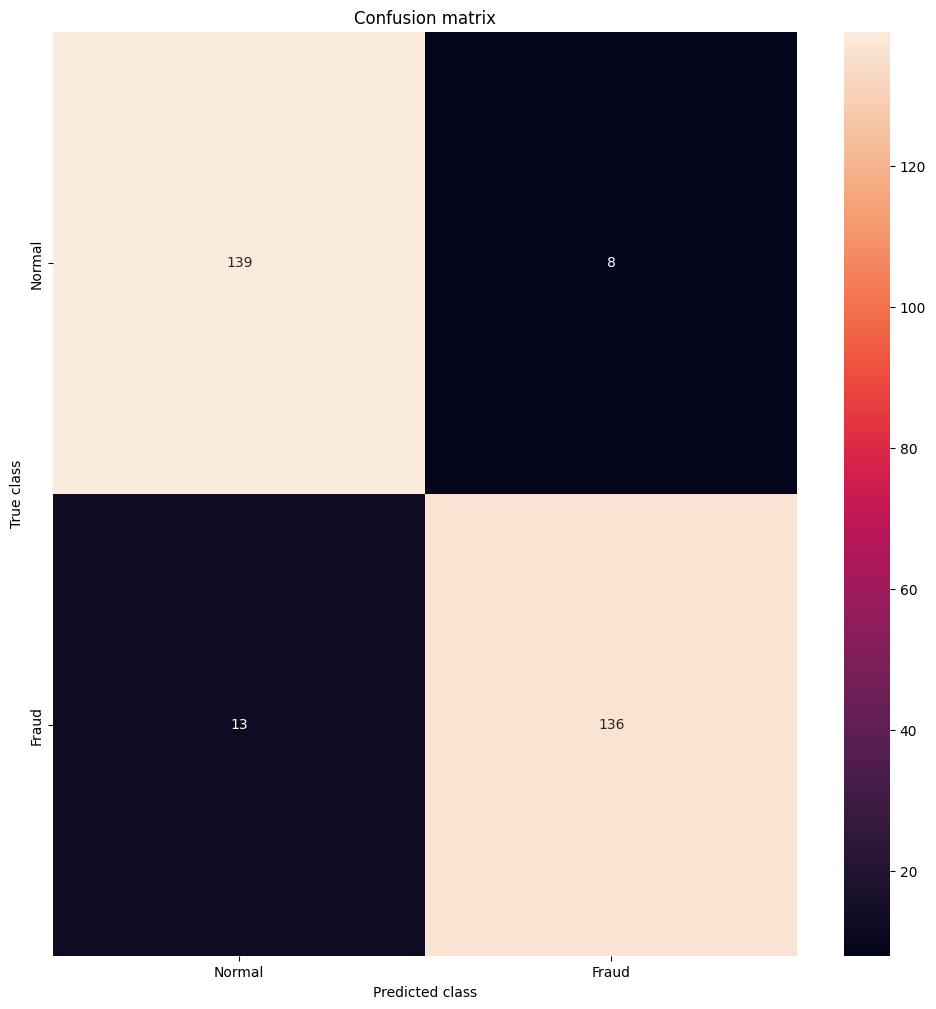

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=1.0, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=1, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=50, n_jobs=None,
               num_parallel_tree=None, random_state=0, ...),
 {'colsample_bytree': 1.0,
  'gamma': 1,
  'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 50,
  'subsample': 0.8})

In [36]:
train_xgb_classifier(df_train,'Class')

In [37]:
# Selcting Best and Highest Accuracy from Above trained Models
# XGb Model Classifier
# Random Forest
models = ['XGB Classifier', 'RandomForestClassifier']
accuracy_scores = [accuracy, accuracy]

# Find the index of the maximum accuracy
best_accuracy_index = accuracy_scores.index(max(accuracy_scores))

# Print the best model for accuracy
print(f'Best Accuracy: {accuracy_scores[best_accuracy_index]:.2f} with Model: {models[best_accuracy_index]}')

Best Accuracy: 0.92 with Model: XGB Classifier


# Observation Set 3:
- I used two models: XGB Classifier and RandomForest Classifier.
- I selected the best model, which is XGB Classifier.
- The best accuracy is 0.93 with model: XGB Classifier.

---

---